# Loan Prediction
### In this notebook we will analyze the data set from Loan prediction III problem from Analytics Vidhya and build models to predict the loan status


#### About Dataset
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.


#### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set



## Load the data and look at summary statistics

In [1]:

import pandas as pd
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
loan = pd.read_csv("loan_predict_train.csv")

In [3]:
loan.shape

(614, 13)

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [5]:
loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
loan.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Target Variable is Loan_Status - let's see its distribution

In [7]:
loan.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

#### The data is moderately unbalanced - minority class is about 31%.

## Exploratory Analysis
#### Is there any trend in loan status based on LoanAmount or Income of applicant/coapplicant ?

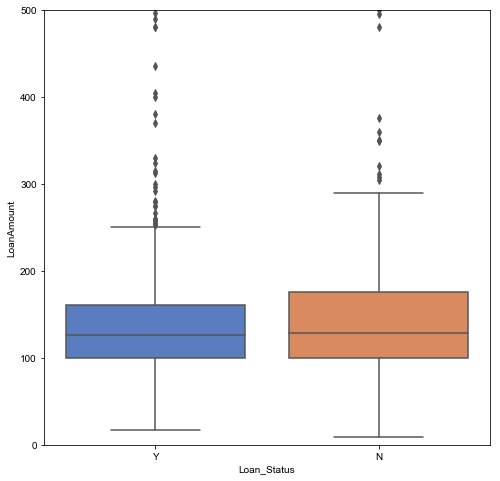

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.style.use('seaborn-whitegrid')
sns.set(palette="muted")
ax.set_ylim(0,500)
ax = sns.boxplot(x="Loan_Status", y="LoanAmount", data=loan)

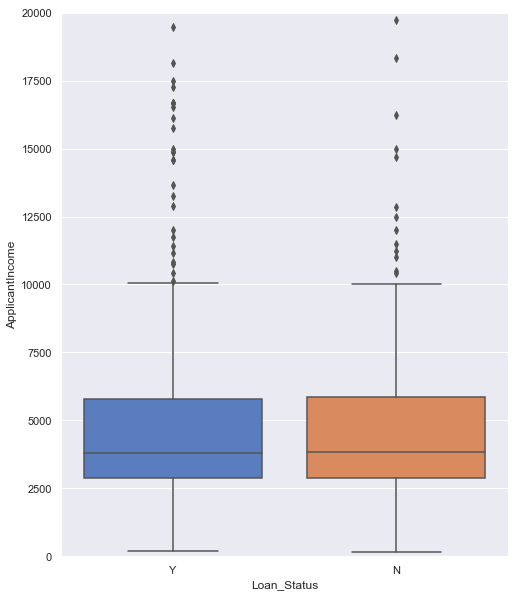

In [9]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_ylim(0,20000)
ax = sns.boxplot(x="Loan_Status", y="ApplicantIncome", data=loan)

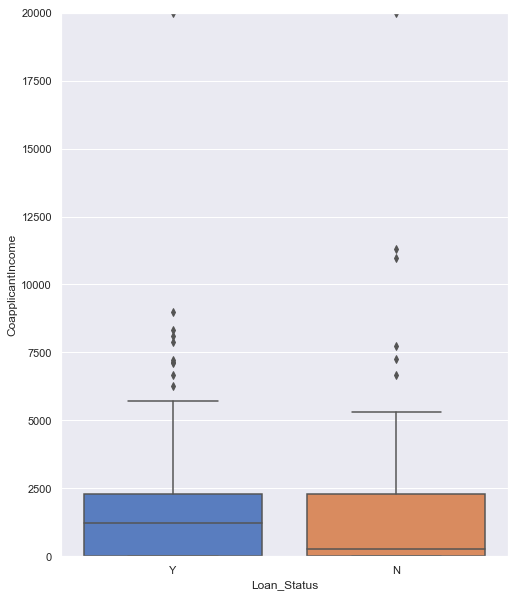

In [10]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_ylim(0,20000)
ax = sns.boxplot(x="Loan_Status", y="CoapplicantIncome", data=loan)

- ###### We can see from above plot that mean coapplicant income is higher for approved loans

### How is approval rate among various categories ?

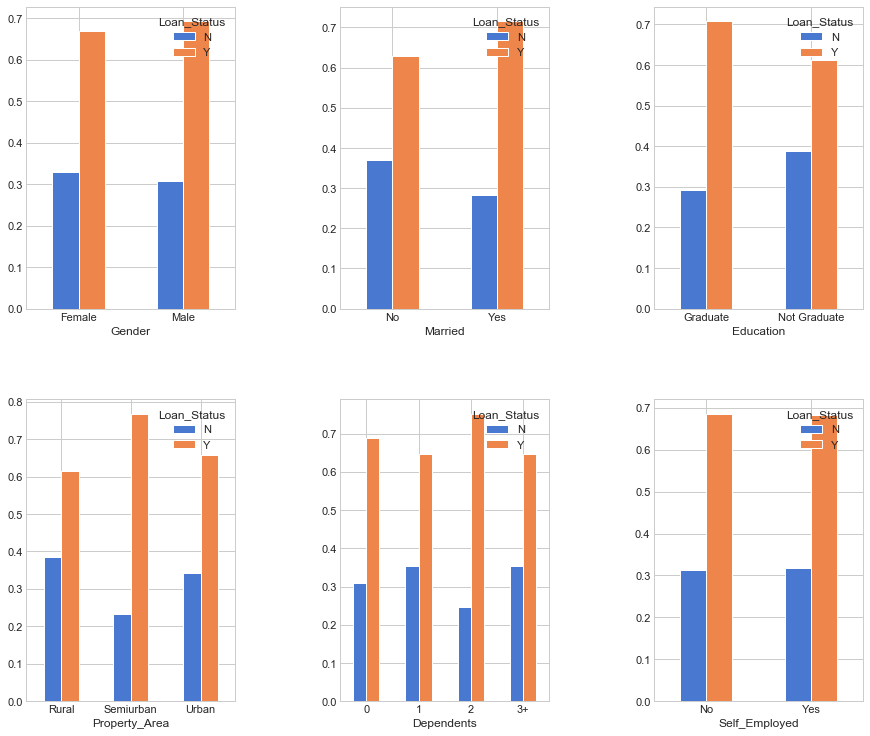

In [11]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
rows = 3
cols = 3
categorical_col = ['Gender', 'Married', 'Education', 'Property_Area', 'Dependents', 'Self_Employed']
for i, column in enumerate(categorical_col):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set(xticks=[])
    ax = pd.crosstab(loan[categorical_col[i]], loan.Loan_Status, normalize='index').plot.bar(ax=ax)

- ###### We can see that SemiUrban properties have relatively higher rate of approval

### Is there any gender bias?

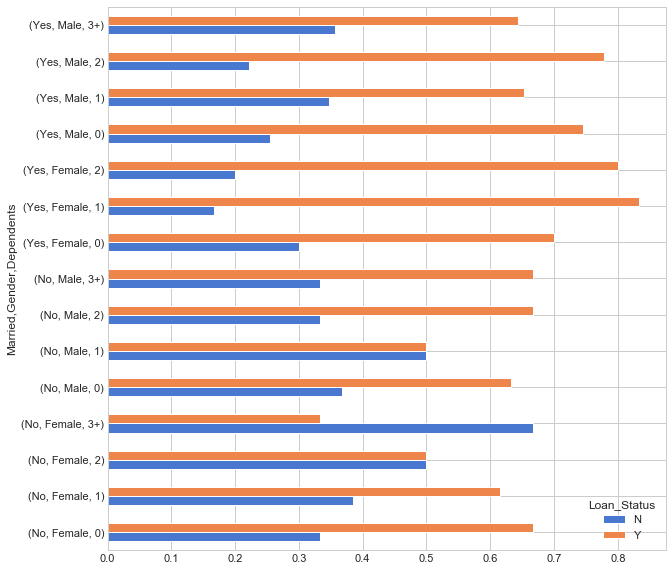

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pd.crosstab([loan.Married, loan.Gender, loan.Dependents], loan.Loan_Status, normalize='index').plot.barh(ax=ax);

- It can be noted from above plot that Unmarried Females with 3+ dependents have very high rate of rejection - let's dive into the details - from the data it doesn't show any gender bias as there are only three samples out of which only one has good credit history

In [13]:
loan.loc[(loan.Gender == 'Female') & (loan.Married == 'No') & (loan.Dependents == '3+')]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
255,LP001846,Female,No,3+,Graduate,No,3083,0.0,255.0,360.0,1.0,Rural,Y
338,LP002113,Female,No,3+,Not Graduate,No,1830,0.0,NaN,360.0,0.0,Urban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N


## Data Preprocessing

### Missing data
- Out of the 13 columns we will exclude Loan_Status and Loan_ID and arrive at 11 predictor variblles. Out of these seven variables have varying degrees of missing values. We need to impute these appropriately.

In [14]:
def do_preprocess(data):
    table = data.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
    def fage(x):
        return table.loc[x['Self_Employed'],x['Education']]
    # Replace missing values
    data['Self_Employed'].fillna('No', inplace=True)
    data['LoanAmount'].fillna(data[data['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
    data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
    data['Married'].fillna(data['Married'].mode()[0], inplace=True)
    data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)


do_preprocess(loan)

### Feature Engineering
- Performance of a model will be greatly influenced by carefully crafted features.
- It is reasonable to assume a loan application is weighed by the ability to repay it. This ability will depend on the applicant's income. Hence we can add a feature of the ratio of there two terms.
- We can come up with the below features
    - ApplicantIncomeByLoanAmount
    - IncomeByLoanAmount - here Income is the total income of applicant and co-applicant

In [15]:
def add_new_features(data):
    data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    data['IncomeByLoanAmount'] = data['TotalIncome'] / data['LoanAmount']
    data['AplIncomeByLoanAmount'] = data['ApplicantIncome'] / data['LoanAmount']
   
add_new_features(loan)

### Encoding Predictors
- As the machine learning algorithms internally operate on matrices of numerical data we need to encode our categorical variables into numberic form.
- The most widely used encoding is the OneHotEncoding and pandas readily provides this functionality

In [16]:
def doOneHotEncoding(data, cols):
    for var in cols:
        one_hot = pd.get_dummies(data[var], prefix = var)
        # Drop column B as it is now encoded
        data = data.drop(var,axis = 1)
        # Join the encoded data
        data = data.join(one_hot)
    return data

loan = doOneHotEncoding(loan, ['Gender', 'Married','Dependents','Education','Self_Employed','Property_Area'])
loan.Loan_Status = loan.Loan_Status.map(dict(Y=1,N=0))

In [17]:
loan.Loan_Status.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

## Building Model
#### We will begin with building a linear model because of its interpretability. Will use statsmodels api to fit the data as it gives detailed statistics on the fitted model. Let's do Logistic Regression on this data.

In [18]:
outcome_var = "Loan_Status"
#exclude baseline categorical variables
predictor_var = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', #'TotalIncome',
       'IncomeByLoanAmount', 'AplIncomeByLoanAmount', #'EMI',
       'Gender_Male', 'Married_No', 'Dependents_0', 'Dependents_1', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban']

logit = sm.Logit(loan[outcome_var], loan[predictor_var])
result = logit.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4547675334738926
            Iterations: 66
            Function evaluations: 93
            Gradient evaluations: 66


c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [19]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.268     
Dependent Variable:   Loan_Status        AIC:                590.4545  
Date:                 2019-03-11 12:12   BIC:                661.1744  
No. Observations:     614                Log-Likelihood:     -279.23   
Df Model:             15                 LL-Null:            -381.45   
Df Residuals:         598                LLR p-value:        2.6620e-35
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       66.0000                                          
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
ApplicantIncome          0.0000   0.0000  0.6772 0.4983 -0.0000  0.0001
CoapplicantIncome       -0.0001   0.0001 -1.5155 0.1296 -0.0003  0.0000
LoanAmount              -0.0022   0.0021 -1.0303 0.3029 -0.0064  0.0020
Loan_Amount_Term        -0.0036   0.0014 -2.6889 0.0072 -0.0063 -0.0010
Credit_History           3.7482   0.3783  9.9068 0.0000  3.0067  4.4898
IncomeByLoanAmount       0.0103   0.0102  1.0082 0.3134 -0.0097  0.0304
AplIncomeByLoanAmount   -0.0144   0.0106 -1.3564 0.1750 -0.0351  0.0064
Gender_Male             -0.2351   0.2890 -0.8136 0.4159 -0.8014  0.3312
Married_No              -0.6078   0.2516 -2.4155 0.0157 -1.1010 -0.1146
Dependents_0            -0.4663   0.3374 -1.3818 0.1670 -1.1276  0.1951
Dependents_1            -0.9294   0.3810 -2.4392 0.0147 -1.6763 -0.1826
Dependents_3+           -0.4559   0.4779 -0.9539 0.3401 -1.3926  0.4808
Education_Not Graduate  -0.5038   0.2549 -1.9765 0.0481 -1.0034 -0.0042
Self_Employed_Yes       -0.0073   0.3172 -0.0231 0.9815 -0.6290  0.6143
Property_Area_Semiurban  0.8283   0.2643  3.1346 0.0017  0.3104  1.3463
Property_Area_Urban      0.1353   0.2555  0.5294 0.5966 -0.3655  0.6361
=======================================================================

"""

In [20]:
pt = result.pred_table()
pt

array([[  83.,  109.],
       [   9.,  413.]])

In [21]:
print ("Accuracy : %s" % "{0:.3%}".format((pt[0,0]+pt[1,1])/pt.sum()))

Accuracy : 80.782%


- Based on p-values we got 6 out of 16 variables as significant
- Let's fit the model with only those variables

In [22]:
predictor_var = ['Loan_Amount_Term', 'Credit_History', 'Property_Area_Semiurban',
                 'Married_No', 'Dependents_1', 'Education_Not Graduate']

In [23]:
logit = sm.Logit(loan[outcome_var], loan[predictor_var])
result = logit.fit_regularized()

c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46570925902958055
            Iterations: 37
            Function evaluations: 42
            Gradient evaluations: 37


In [24]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.250     
Dependent Variable:   Loan_Status        AIC:                583.8910  
Date:                 2019-03-11 12:12   BIC:                610.4109  
No. Observations:     614                Log-Likelihood:     -285.95   
Df Model:             5                  LL-Null:            -381.45   
Df Residuals:         608                LLR p-value:        2.3880e-39
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       37.0000                                          
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Loan_Amount_Term        -0.0057   0.0010 -5.8087 0.0000 -0.0076 -0.0038
Credit_History           3.4846   0.3461 10.0672 0.0000  2.8062  4.1630
Property_Area_Semiurban  0.7526   0.2286  3.2918 0.0010  0.3045  1.2007
Married_No              -0.5791   0.2172 -2.6658 0.0077 -1.0049 -0.1533
Dependents_1            -0.5738   0.2689 -2.1342 0.0328 -1.1008 -0.0468
Education_Not Graduate  -0.4459   0.2425 -1.8388 0.0659 -0.9211  0.0294
=======================================================================

"""

In [25]:
pt = result.pred_table()
pt

array([[  83.,  109.],
       [   7.,  415.]])

In [26]:
print ("Accuracy : %s" % "{0:.3%}".format((pt[0,0]+pt[1,1])/pt.sum()))

Accuracy : 81.107%


- Dropping insignificant variables slightly improved the accuracy.

### Interpretation
#### - Having good credit history changes the log odds of loan approval by 3.4846
#### - For every unit change in Loan Amount Term the log odds of loan approval decreases by 0.0057 units
#### - Buying a property located in SemiUrban area as compared to a Rural area changes the log odds of loan approval by 0.7526 units

### Model Evaluation
#### A single fit is not sufficient and we need to Evaluate the model to ensure that it generalizes well. We need scikit learn api for cross validation.

#### In classification, Accuracy does not tell the whole story particularly in unbalanced datasets - we need to look at the precision and recall of the classifier on each class to understand the how well the classfier is doing its job.

Let's fit Logistic Regression classfier from scikit-learn

In [27]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression(random_state=42)

In [28]:
def classify_and_report_metrics(model, data, predictors, outcome):
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[outcome], random_state=42, stratify=loan[outcome_var])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy on test set: %s' % '{0:.3%}'.format(model.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred))

In [29]:
##adding all non-base levels of categorical variables that were found significant
predictor_var += ['Dependents_0', 'Dependents_3+', 'Property_Area_Urban']
predictor_var_logistic = predictor_var

##### Split the data into train and test - fit the model on train dataset and test on the test set

In [30]:
classify_and_report_metrics(model_logistic, loan, predictor_var, outcome_var)

Accuracy on test set: 85.714%
[[ 27  21]
 [  1 105]]
             precision    recall  f1-score   support

          0       0.96      0.56      0.71        48
          1       0.83      0.99      0.91       106

avg / total       0.87      0.86      0.84       154



##### Now perform a Five fold cross validation

In [31]:
def fit_and_validate(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

    cm = confusion_matrix(data[outcome], predictions)
    print(cm)
    print(classification_report(data[outcome], predictions))    
    
    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    if (isinstance(model, (RandomForestClassifier))):
            #Create a series with feature importances:
            featimp = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
            print (featimp)
            if (isinstance(model, RandomForestClassifier)):
                if model.get_params()['oob_score']:
                    print('OOB Score %f' % (1 - model.oob_score_))
                else:
                    print('OOB Score False')

In [32]:
fit_and_validate(model_logistic, loan, predictor_var, outcome_var)

Accuracy : 80.945%
[[ 82 110]
 [  7 415]]
             precision    recall  f1-score   support

          0       0.92      0.43      0.58       192
          1       0.79      0.98      0.88       422

avg / total       0.83      0.81      0.78       614

Cross-Validation Score : 81.109%


### Let's see if we can improve the accuracy. We will use Random Forest classifier as it,

#### - Works well for classification
#### - Robust to outliers in the data
#### - Relatively easy to tune
#### - Provides out of bag error rate indicative of the unbiased nature of the fit

#### For fitting a RandomForest model, we will include,
- Variables with top two highest coefficients by Linear Model (Credit_History and Property_Area_Semiurban)
- Two additonal Features created earlier (IncomeByLoanAmount, AplIncomeByLoanAmount)
- ApplicantIncome and LoanAmount which has many outliers

In [44]:
predictor_var = [
 'Credit_History', 'IncomeByLoanAmount', 'AplIncomeByLoanAmount',
    'LoanAmount','Property_Area_Semiurban', 'ApplicantIncome'
]
predictor_var_rf = predictor_var

- Fit the model using the tuned parameters

In [34]:
model_rf = RandomForestClassifier(random_state=42, n_estimators=200, bootstrap= True, oob_score=True)

- Split the data, train the model and verify on the test set

In [35]:
classify_and_report_metrics(model_rf, loan, predictor_var, outcome_var)

Accuracy on test set: 83.766%
[[31 17]
 [ 8 98]]
             precision    recall  f1-score   support

          0       0.79      0.65      0.71        48
          1       0.85      0.92      0.89       106

avg / total       0.83      0.84      0.83       154



- Perform 5-fold cross validation

In [36]:
fit_and_validate(model_rf, loan, predictor_var, outcome_var)

Accuracy : 100.000%
[[192   0]
 [  0 422]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       192
          1       1.00      1.00      1.00       422

avg / total       1.00      1.00      1.00       614

Cross-Validation Score : 80.289%
Credit_History             0.258500
IncomeByLoanAmount         0.211116
AplIncomeByLoanAmount      0.185765
ApplicantIncome            0.163170
LoanAmount                 0.151977
Property_Area_Semiurban    0.029473
dtype: float64
OOB Score 0.211382


#### Cross validation score is lower than Logistic Regression. Let's tune the model to find the best hyperparameters for the RandomForestClassifier

In [37]:
import pprint as pp
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(loan[predictor_var], loan[outcome_var])
rf_random.best_params_

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

#### Create the model with tuned parameters

In [42]:
model_rf = RandomForestClassifier(random_state=42, n_estimators= 1600, min_samples_split= 2, 
                                  min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True, oob_score=True)


In [43]:
fit_and_validate(model_rf, loan, predictor_var, outcome_var)

Accuracy : 85.179%
[[111  81]
 [ 10 412]]
             precision    recall  f1-score   support

          0       0.92      0.58      0.71       192
          1       0.84      0.98      0.90       422

avg / total       0.86      0.85      0.84       614

Cross-Validation Score : 81.757%
Credit_History             0.412341
IncomeByLoanAmount         0.173988
AplIncomeByLoanAmount      0.139973
LoanAmount                 0.118749
ApplicantIncome            0.118692
Property_Area_Semiurban    0.036256
dtype: float64
OOB Score 0.184959


##### This has given much better accuracy than LogisticRegression. Let's verify this by plotting the  ROC AUC.

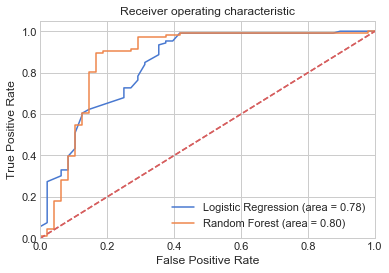

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test, logistic_model.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1])
X_train, X_test, y_train, y_test = train_test_split(loan[predictor_var_logistic], loan[outcome_var], random_state=42, stratify=loan[outcome_var])
model_logistic.fit(X_train, y_train)
logit_roc_auc = roc_auc_score(y_test, model_logistic.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_logistic.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

X_train, X_test, y_train, y_test = train_test_split(loan[predictor_var_rf], loan[outcome_var], random_state=42, stratify=loan[outcome_var])
model_rf.fit(X_train, y_train)
logit_roc_auc = roc_auc_score(y_test, model_rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])
# plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### The RandomForest gave a better AUC score proving its superiority over LogisticRegression for this dataset.

## Conclusion

   #### "All models are wrong, but some are useful"        ------Box, George E. P

##### As the above mentioned aphorism states all models are simplifications of reality and in our given problem the fit given by RandomForestClassifier is found to be more accurate in predicting the outcome. Hence it will be adopted for this use case.